# Application: `JaxILI` to perform inference on Power Spectrum mock data from `jax_cosmo`

*Author: Sacha Guerrini*

In [55]:
%load_ext autoreload
%autoreload 2

import os
from copy import copy
import logging  

os.environ["CUDA_VISIBLE_DEVICES"] = ""
logging.getLogger("absl").setLevel("WARNING")

#import libraries
import warnings
from tqdm import tqdm
from typing import Any, Sequence
warnings.filterwarnings("ignore")

import numpy as np
import scipy.stats as stats
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from chainconsumer import ChainConsumer
import jax_cosmo as jc
import haiku as hk
import optuna
import optax

#Tensorflow import
import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions

#Torch import
import torch
import torch.utils.data as data

#JaxILI import
from jaxili.utils import create_data_loader
from jaxili.model import ConditionalRealNVP, ConditionalMAF, MixtureDensityNetwork
from jaxili.train import TrainerModule, TrainState

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
jax.devices() #Shows if the code runs on CPU or GPU.

[CpuDevice(id=0)]

## Simulation

In this notebook, we use `jax_cosmo` to simulate $C_l$'s from a power spectrum using a Planck (2015) fiducial cosmology. The goal is here to demonstrate how `jaxili` allows to obtain constraints on the cosmological parameters using the power spectrum in the case of a simple simulator.

In [3]:
cosmo = jc.Planck15() #Create a cosmology with default parameters
cosmo

Cosmological parameters: 
    h:        0.6774 
    Omega_b:  0.0486 
    Omega_c:  0.2589 
    Omega_k:  0.0 
    w0:       -1.0 
    wa:       0.0 
    n:        0.9667 
    sigma8:   0.8159

In [4]:
nz = jc.redshift.smail_nz(1., 2., 0.75, gals_per_arcmin2=6)
tracer = jc.probes.WeakLensing([nz])

fiducial_params = jnp.array([cosmo.Omega_c, cosmo.sigma8])

ell = jnp.logspace(2, np.log10(2000), 20)

#Compute the mean and covariance matrix for this cosology and this tracer
mu, cov = jc.angular_cl.gaussian_cl_covariance_and_mean(cosmo, ell, [tracer], f_sky=0.125)

In [5]:
#Let's build a simulator that returns a sample of Cl for a given cosmology
@jax.jit
def sample_likelihood(params, key):
    cosmo = jc.Planck15(Omega_c=params[0], sigma8=params[1])
    mu = jc.angular_cl.angular_cl(cosmo, ell, [tracer]).flatten()
    dist = tfd.MultivariateNormalDiag(loc=mu, scale_diag=jnp.sqrt(jnp.diag(cov)))
    return dist.sample(seed=key)

In [6]:
observation = sample_likelihood(fiducial_params, jax.random.PRNGKey(0))

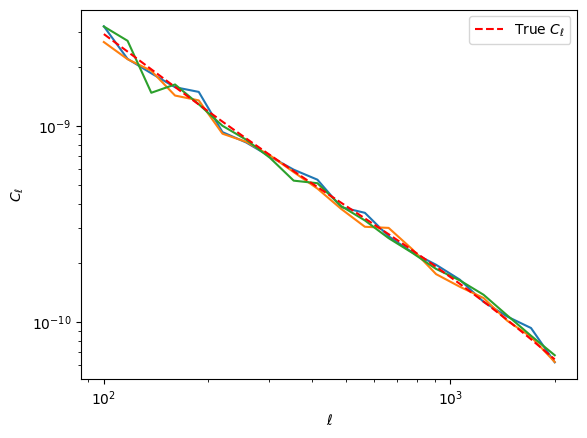

In [7]:
plt.figure()

plt.loglog(ell, sample_likelihood(fiducial_params, jax.random.PRNGKey(0)))
plt.loglog(ell, sample_likelihood(fiducial_params, jax.random.PRNGKey(1)))
plt.loglog(ell, sample_likelihood(fiducial_params, jax.random.PRNGKey(2)))
plt.xlabel(r"$\ell$")
plt.ylabel(r"$C_\ell$")

plt.loglog(ell, mu, color='red', linestyle='--', label="True $C_\ell$")
plt.legend()
plt.show()

Sampling from the covariance allows to recover a noisy vector as output of the simulation which makes the latter stochastic.

In [8]:
seq = hk.PRNGSequence(42)

def simulator(theta):
    return sample_likelihood(theta, next(seq))

In [9]:
theta = np.array([0.3, 0.8])

%timeit simulator(theta).block_until_ready()

103 ms ± 5.43 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
#Generate parameters
dim_params = 2
dim_obs = 20

def generate_thetas(n_samples, dim):
    thetas =  stats.qmc.LatinHypercube(d=dim).random(n_samples)
    thetas = stats.qmc.scale(thetas, np.array([0.1, 0.1]), np.array([1, 1]))
    return thetas

In [8]:
class PowerSpectrumDataset(data.Dataset):
    def __init__(self, num_data, dim):
        self.thetas = generate_thetas(num_data, dim)
        self.xs = []
        for theta in self.thetas:
            self.xs.append(simulator(theta))
        self.thetas, self.xs = np.array(self.thetas), np.array(self.xs)

    def __len__(self):
        return len(self.thetas)
    
    def __getitem__(self, idx):
        return self.thetas[idx], self.xs[idx]

    def set_params(self, thetas):
        self.thetas = thetas
    
    def set_simulation(self, xs):
        self.xs = xs
    
train_set_size = 5000
val_set_size = 1000
test_set_size = 2000

#Create the datasets
train_set = PowerSpectrumDataset(train_set_size, dim_params)
print("Train_set created")
val_set = PowerSpectrumDataset(val_set_size, dim_params)
print("Val_set created")
test_set = PowerSpectrumDataset(test_set_size, dim_params)
print("Test_set created")

#Specify the batch_size
batch_size = 128
train_loader, val_loader, test_loader = create_data_loader(
    train_set, val_set, test_set,
    train = [True, False, False],
    batch_size = 128
)

KeyboardInterrupt: 

In [ ]:
#Save datset
torch.save(train_set, 'ps_dataset/train_set.pt')
torch.save(val_set, 'ps_dataset/val_set.pt')
torch.save(test_set, 'ps_dataset/test_set.pt')

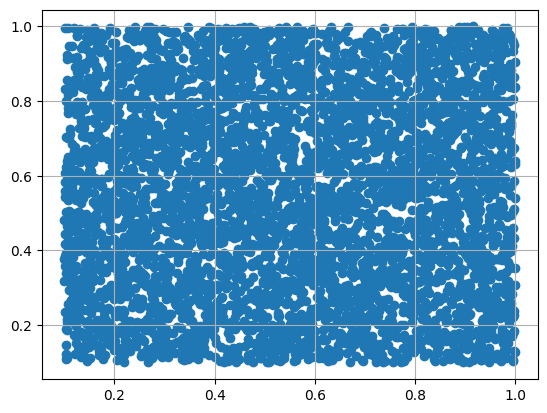

In [79]:
plt.figure()

plt.scatter(train_set.thetas[:, 0], train_set.thetas[:, 1], label="Train set")
plt.grid()
plt.show()

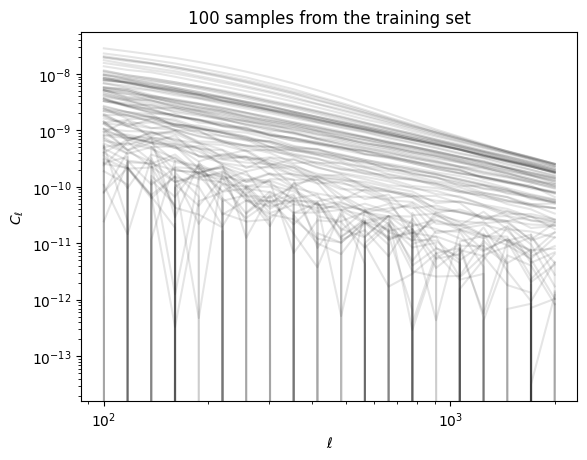

In [80]:
plt.figure()

for sim in train_set.xs[:100]:
    plt.loglog(ell, sim, color='black', alpha=0.1)
plt.xlabel(r"$\ell$")
plt.ylabel(r"$C_\ell$")
plt.title("100 samples from the training set")
plt.show()


## Neural Posterior Estimation

We will first perform Neural Posterior Estimation using `JaxILI`. For now, the normalisation of the data is handled by hand. See later updates for automatic renormalisation of the data.

In [11]:
class PowerSpectrumDataset(data.Dataset):
    def __init__(self, num_data, dim):
        self.thetas = generate_thetas(num_data, dim)
        self.xs = []
        for theta in self.thetas:
            self.xs.append(simulator(theta))
        self.thetas, self.xs = jnp.array(self.thetas), jnp.array(self.xs)

    def __len__(self):
        return len(self.thetas)
    
    def __getitem__(self, idx):
        return self.thetas[idx], self.xs[idx]
    
    def set_params(self, thetas):
        self.thetas = thetas

    def set_simulation(self, xs):
        self.xs = xs

train_set = torch.load('ps_dataset/train_set.pt')
val_set = torch.load('ps_dataset/val_set.pt')
test_set = torch.load('ps_dataset/test_set.pt')

#Normalize the data.
thetas, xs = train_set[:]
xs_mean = xs.mean(axis=0)
xs_std = xs.std(axis=0)
train_set.set_simulation(np.array((xs - xs_mean) / xs_std))
train_set.set_params(np.array(thetas))
thetas, xs = val_set[:]
val_set.set_simulation(np.array((xs - xs_mean) / xs_std))
val_set.set_params(np.array(thetas))
thetas, xs = test_set[:]
test_set.set_simulation(np.array((xs - xs_mean) / xs_std))
test_set.set_params(np.array(thetas))

#Specify the batch_size
batch_size = 50
train_loader, val_loader, test_loader = create_data_loader(
    train_set, val_set, test_set,
    train = [True, False, False],
    batch_size = batch_size
)

CHECKPOINT_PATH = '~/Documents/jaxili/notebooks/checkpoints_ps/'

dim_params = 2
dim_obs = 20

In [12]:
class MDNTrainer(TrainerModule):#Inherits from TrainerModule to use the training loop
    def __init__(self, #Overload __init__ with hyperparameters of the network
                 n_data : int,
                 n_components : int,
                 layers : Sequence[int],  
                 activation : str,
                 trial : Any = None,
                 **kwargs):
        super().__init__(model_class=MixtureDensityNetwork,
                         model_hparams={
                            'n_data': n_data,
                            'n_components': n_components,
                            'layers': layers,
                            'activation': activation
                         },
                         **kwargs)
        self.trial = trial

    def create_functions(self): #The user has to create this function to initialize the train_step and test_step.
        def loss_nll(params, batch):
            thetas, xs = batch
            return -jnp.mean(self.model.apply({'params': params}, thetas, xs, method='log_prob'))
        
        def train_step(state, batch):
            loss_fn = lambda params: loss_nll(params, batch)
            loss, grads = jax.value_and_grad(loss_fn)(state.params)
            state = state.apply_gradients(grads=grads)
            metrics = {'loss': loss}
            return state, metrics
        
        def eval_step(state, batch):
            loss = loss_nll(state.params, batch)
            return {'loss': loss}
        
        return train_step, eval_step

    def print_tabulate(self, exmp_input):
         pass
        
    def on_validation_epoch_end(self, epoch_idx, eval_metrics, val_loader):
        if self.trial:
            self.trial.report(eval_metrics['val/loss'], step=epoch_idx)
            if self.trial.should_prune():
                raise optuna.exceptions.TrialPruned()
            
class MAFTrainer(TrainerModule):
    def __init__(self,
                 n_in : int,
                 n_cond : int,
                 n_layers : int,
                 layers : list[int],
                 use_reverse : bool,
                 seed : int = 42,
                 activation : str = 'silu',
                 trial : Any = None,
                 **kwargs
                 ):
        super().__init__(model_class=ConditionalMAF,
                         model_hparams={
                             'n_in': n_in,
                             'n_cond': n_cond,
                             'n_layers': n_layers,
                             'layers': layers,
                             'use_reverse': use_reverse,
                             'seed': seed,
                             'activation': activation,
                         },
                         
                         **kwargs)
        self.trial = trial
        
    def create_functions(self):
        def loss_nll(params, batch, train):
            thetas, xs = batch
            output = self.model.apply(
                {'params': params},
                  thetas, xs, train,
                  method='log_prob')
            return -jnp.mean(output)
        
        def train_step(state, batch):
            loss_fn = lambda params: loss_nll(params, batch, train=True)
            loss, grads = jax.value_and_grad(loss_fn)(state.params)
            #print(loss)
            state = state.apply_gradients(grads=grads)
            #state = state.replace(batch_stats=updates['batch_stats'])
            metrics = {'loss': loss}
            return state, metrics
        
        def eval_step(state, batch):
            loss = loss_nll(state.params, batch, train=False)
            return {'loss': loss}
        
        return train_step, eval_step
    
    def generate_config(self, logger_params):
        self.config = {
            'model_class': self.model_class.__name__,
            'model_hparams': copy(self.model_hparams),
            'optimizer_hparams': self.optimizer_hparams,
            'logger_params': logger_params,
            'enable_progress_bar': self.enable_progress_bar,
            'debug': self.debug,
            'check_val_every_epoch': self.check_val_every_epoch,
            'seed': self.seed
        }

    def init_optimizer(self,
                       num_epochs : int,
                       num_steps_per_epoch : int):
        """
        Initializes the optimizer and learning rate scheduler.

        Parameters
        ----------
        num_epochs : Number of epochs to train.
        num_steps_per_epoch : Number of steps per epoch.
        """

        hparams = copy(self.optimizer_hparams)

        #Initialize optimizer
        optimizer_name = hparams.pop('optimizer_name', 'adam')
        if optimizer_name.lower() == 'adam':
            opt_class = optax.adam
        elif optimizer_name.lower() == 'sgd':
            opt_class = optax.sgd
        elif optimizer_name.lower() == 'adamw':
            opt_class = optax.adamw
        else:
            assert False, f'Unknown optimizer \"{optimizer_name}\"'
        #Initialize learning rate scheduler
        #A cosine decay scheduler is used, but others are also possible
        lr = hparams.pop('lr', 1e-3)
        warmup = hparams.pop('warmup', 0.1)
        lr_schedule = optax.warmup_cosine_decay_schedule(
            init_value=0.0,
            peak_value=lr,
            warmup_steps=warmup,
            decay_steps=int(num_epochs * num_steps_per_epoch),
            end_value=0.01 * lr
        )
        #Clip gradients at max value, and evt. apply weight decay
        transf = [optax.clip_by_global_norm(hparams.pop('gradient_clip', 5.0))]
        if opt_class == optax.sgd and 'weight_decay' in hparams:
            transf.append(optax.add_decayed_weights(hparams.pop('weight_decay', 0.0)))
        optimizer = optax.chain(
            *transf,
            opt_class(lr_schedule, **hparams)
        )
        #Initialize training state
        self.state = TrainState.create(
            apply_fn=self.state.apply_fn,
            params=self.state.params,
            batch_stats=self.state.batch_stats,
            tx=optimizer,
            rng=self.state.rng
        )
        
    def print_tabulate(self, exmp_input):
        pass

class RealNVPTrainer(TrainerModule):
    def __init__(self,
                 n_in : int,
                 n_layers : int,
                 layers : list[int],
                 activation : str,
                 trial : Any = None,
                 **kwargs):
        super().__init__(model_class=ConditionalRealNVP,
                         model_hparams={
                             'n_in': n_in,
                             'n_layers': n_layers,
                             'layers' : layers,
                             'activation' : activation
                         },
                         **kwargs)
    
        self.trial=trial
        
    def create_functions(self):
        def loss_nll(params, batch):
            thetas, xs = batch
            return -jnp.mean(self.model.apply({'params': params}, thetas, xs, method='log_prob'))
        
        def train_step(state, batch):
            loss_fn = lambda params: loss_nll(params, batch)
            loss, grads =jax.value_and_grad(loss_fn)(state.params)
            state = state.apply_gradients(grads=grads)
            metrics = {'loss': loss}
            return state, metrics
        
        def eval_step(state, batch):
            loss = loss_nll(state.params, batch)
            return {'loss': loss}
        
        return train_step, eval_step
    
    def run_model_init(self, exmp_input, init_rng):
        return self.model.init(init_rng, *exmp_input, train=True, method='log_prob')
    
    def print_tabulate(self, exmp_input):
        pass

    def on_validation_epoch_end(self, epoch_idx, eval_metrics, val_loader):
        if self.trial:
            self.trial.report(eval_metrics['val/loss'], step=epoch_idx)
            if self.trial.should_prune():
                raise optuna.exceptions.TrialPruned()

In [25]:
CHECKPOINT_PATH = '~/Documents/jaxili/notebooks/checkpoints_ps/'

dim_params = 2
dim_obs = 20

trainer = MAFTrainer( #There is some issue with the MAF with an odd number of layers that returns fliped samples.
    n_in=dim_params,
    n_cond=dim_obs,
    n_layers=5,
    layers=[50, 50],
    use_reverse=True,
    seed=30,
    activation='relu',
    optimizer_hparams={
        'lr': 5e-4,
        'optimizer_name': 'adam'
    },
    logger_params={'base_log_dir': CHECKPOINT_PATH},
    exmp_input=next(iter(train_loader)),
    check_val_every_epoch=1,
    trial=None,
    debug=False
)

In [26]:
#Let's have a look at the output of the network before training
key = jax.random.PRNGKey(0)
samples = trainer.model.apply(
    {'params': trainer.state.params}, observation.reshape((-1, 20)), num_samples=10000, key=key, method='sample'
)

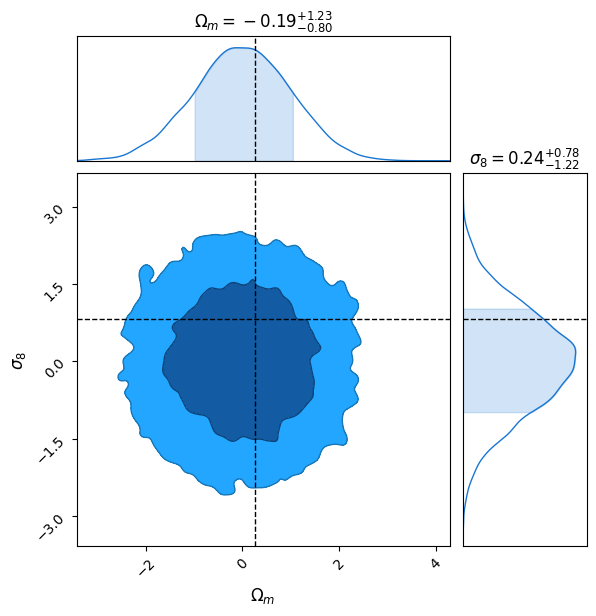

In [27]:
c = ChainConsumer()
c.add_chain(samples, parameters=[r"$\Omega_m$", r"$\sigma_8$"])
fig = c.plotter.plot(figsize=2., truth=np.array(fiducial_params))
plt.show()


In [28]:
metrics = trainer.train_model(
    train_loader, val_loader, test_loader=test_loader, num_epochs=200, patience=20
)

Epochs: Best epoch 191, Best val loss -4.004: 100%|██████████| 200/200 [02:12<00:00,  1.51it/s]


In [29]:
print(f'Training loss: {metrics["train/loss"]}')
print(f'Validation loss: {metrics["val/loss"]}')
print(f'Test loss: {metrics["test/loss"]}')

Training loss: -4.059952735900879
Validation loss: -4.003671169281006
Test loss: -4.083435535430908


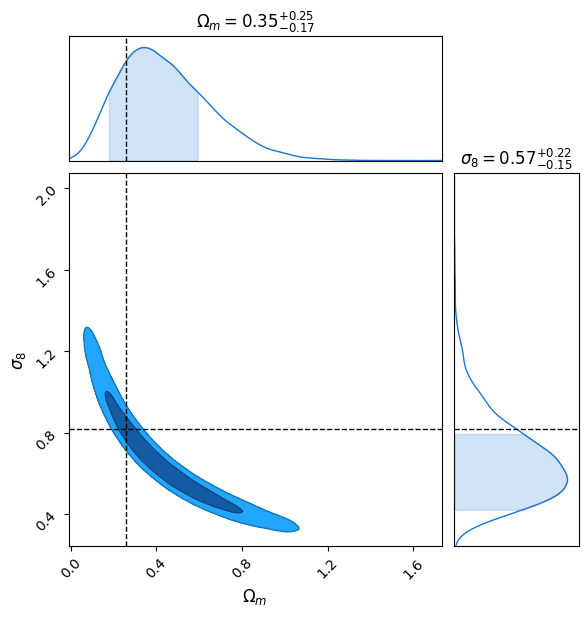

In [30]:
model = trainer.bind_model()

#Let's have a look at the output of the network after training
key = jax.random.PRNGKey(0)
samples_maf = model.sample(
    (observation.reshape((-1, 20))-xs_mean)/xs_std, num_samples=10000, key=key
)

c = ChainConsumer()
c.add_chain(samples_maf, parameters=[r"$\Omega_m$", r"$\sigma_8$"])
fig = c.plotter.plot(figsize=2., truth=np.array(fiducial_params))
plt.show()

In [19]:
log_prob = model.log_prob(samples_maf, (observation.reshape((-1, 20))-xs_mean)/xs_std*jnp.ones((10000, 1)))

In [20]:
print(f"Loss: {-jnp.mean(log_prob):.3f}" )

Loss: -4.092


We can also to try to use other architectures such the `ConditionalRealNVP` or the `MixtureDensityNetwork`.

In [56]:
trainer = RealNVPTrainer(n_in=dim_params,
                         n_layers=4,
                        layers=[50, 50],
                        activation = 'silu',
                        optimizer_hparams={'lr': 5e-4},
                        logger_params={'base_log_dir': CHECKPOINT_PATH},
                        exmp_input=next(iter(train_loader)),
                        check_val_every_epoch=1,
                        seed=0)

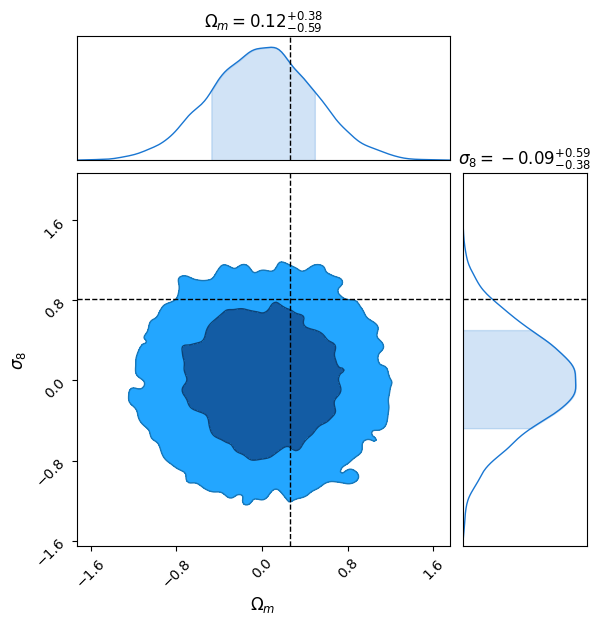

In [58]:
#Let's have a look at the output of the network before training
key = jax.random.PRNGKey(0)
samples = trainer.model.apply(
    {'params': trainer.state.params}, (observation-xs_mean)/xs_std, num_samples=10000, key=key, method='sample'
)

c = ChainConsumer()
c.add_chain(samples, parameters=[r"$\Omega_m$", r"$\sigma_8$"])
fig = c.plotter.plot(figsize=2., truth=np.array(fiducial_params))
plt.show()


In [59]:
metrics = trainer.train_model(
    train_loader, val_loader, test_loader=test_loader, num_epochs=200, patience=20
)

Epochs: Val loss -3.923/ Best val loss -3.929: 100%|██████████| 200/200 [02:16<00:00,  1.47it/s]


In [60]:
print(f'Training loss: {metrics["train/loss"]}')
print(f'Validation loss: {metrics["val/loss"]}')
print(f'Test loss: {metrics["test/loss"]}')

Training loss: -3.98576283454895
Validation loss: -3.929879903793335
Test loss: -3.9956607818603516


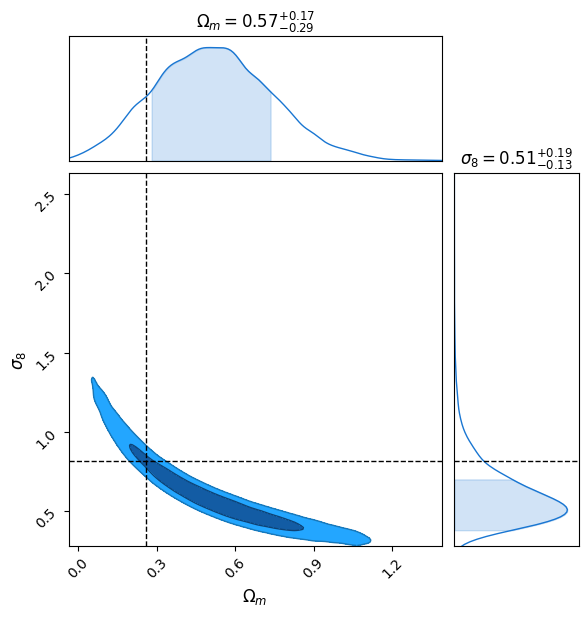

In [62]:
model = trainer.bind_model()

#Let's have a look at the output of the network after training
key = jax.random.PRNGKey(0)
samples_rnvp = model.sample(
    (observation-xs_mean)/xs_std, num_samples=10000, key=key
)

c = ChainConsumer()
c.add_chain(samples_rnvp, parameters=[r"$\Omega_m$", r"$\sigma_8$"])
fig = c.plotter.plot(figsize=2., truth=np.array(fiducial_params))
plt.show()

In [43]:
trainer = MDNTrainer(n_data=dim_params, #Create your trainer
                            n_components=4,
                            layers=[128, 128],
                            activation='silu',
                            optimizer_hparams={'lr': 5e-4},
                            logger_params={'base_log_dir': CHECKPOINT_PATH},
                            exmp_input=next(iter(train_loader)), #beware of the training input.
                            check_val_every_epoch=5
                            )

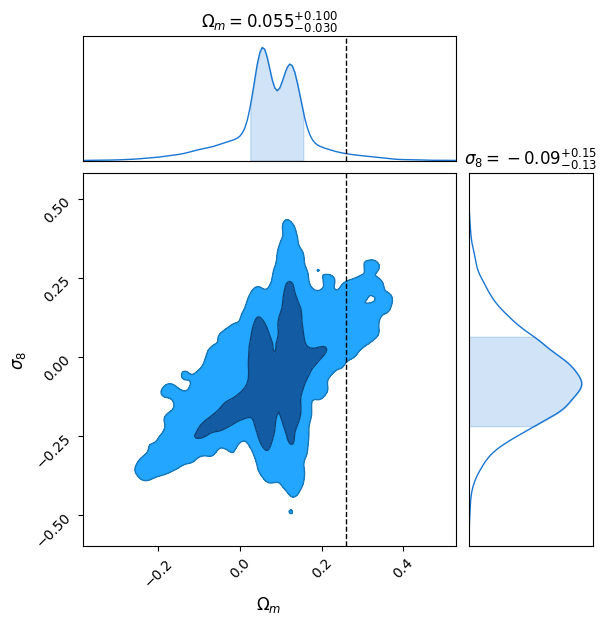

In [44]:
#Let's have a look at the output of the network before training
key = jax.random.PRNGKey(0)
samples = trainer.model.apply(
    {'params': trainer.state.params}, (observation.reshape((-1, 20))-xs_mean)/xs_std, num_samples=10000, key=key, method='sample'
)

c = ChainConsumer()
c.add_chain(samples, parameters=[r"$\Omega_m$", r"$\sigma_8$"])
fig = c.plotter.plot(figsize=2., truth=np.array(fiducial_params))
plt.show()

In [45]:
metrics = trainer.train_model(
    train_loader, val_loader, test_loader=test_loader, num_epochs=200, patience=20
)

Epochs: Val loss -3.699/ Best val loss -3.699: 100%|██████████| 200/200 [00:51<00:00,  3.87it/s]


In [46]:
print(f'Training loss: {metrics["train/loss"]}')
print(f'Validation loss: {metrics["val/loss"]}')
print(f'Test loss: {metrics["test/loss"]}')

Training loss: -3.8128011226654053
Validation loss: -3.698643445968628
Test loss: -3.7180817127227783


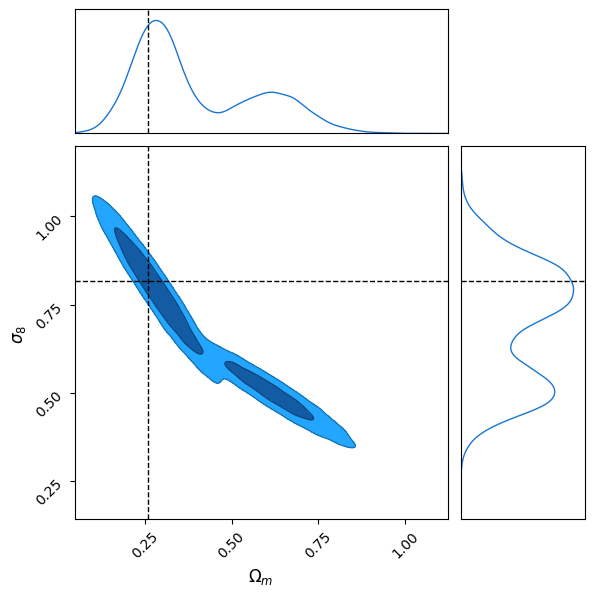

In [47]:
model = trainer.bind_model()

#Let's have a look at the output of the network after training
key = jax.random.PRNGKey(0)
samples_mdn = model.sample(
    (observation.reshape((-1, 20))-xs_mean)/xs_std, num_samples=10000, key=key
)

c = ChainConsumer()
c.add_chain(samples_mdn, parameters=[r"$\Omega_m$", r"$\sigma_8$"])
fig = c.plotter.plot(figsize=2., truth=np.array(fiducial_params))
plt.show()

Let's finally compare the constraints obtained with the different architectures:

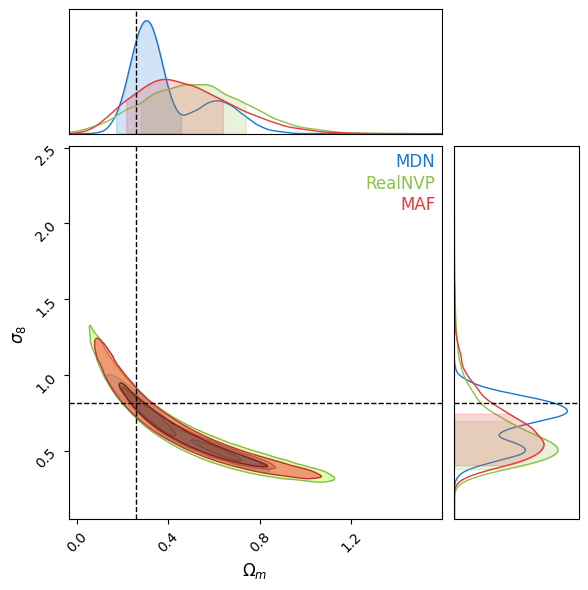

In [32]:
c = ChainConsumer()
c.add_chain(samples_mdn, parameters=[r"$\Omega_m$", r"$\sigma_8$"], name="MDN")
c.add_chain(samples_rnvp, parameters=[r"$\Omega_m$", r"$\sigma_8$"], name="RealNVP")
c.add_chain(samples_maf, parameters=[r"$\Omega_m$", r"$\sigma_8$"], name="MAF")
fig = c.plotter.plot(figsize=2., truth=np.array(fiducial_params))
plt.show()